<a href="https://colab.research.google.com/github/stefanogiagu/corsoinfn/blob/main/notebooks2/Hands_on_3_CNN_su_Acceleratori_FPGA_7_12_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Training e compressione/semplificazione di una CNN per la ricostruzione a bassissima latenza di muoni del rivelatore RPC dell'esperimento ATLAS **

*   training di un modello teacher CNN VGG-like
*   compressione tramite quantizzazione a 4bit con QKeras
*   training di un modello student VGG semplificato + quantizzato a 4 bit
*   ottmizzazione delle prestazioni del modello student via teacher-student knoweldge distillation
*   conversione del modello in VHDL con hls4ml


Referenze:<p>
[articolo riferimento](https://epjc.epj.org/articles/epjc/abs/2021/11/10052_2021_Article_9770/10052_2021_Article_9770.html) <p>
[Q-keras](https://github.com/google/qkeras) <p>
[hls4ml](https://fastmachinelearning.org/hls4ml/) <p>
[Vivado](https://www.xilinx.com/products/design-tools/vivado.html)

Dataset disponibile su google drive e accessibile da google colab:

https://drive.google.com/drive/folders/1mAvJEI9KWWNRLCq3d5VROHPVtei6SZkV?usp=sharing

aprire il file dal browser, aggiungere uno short cut al proprio google drive, e poi montare il google drive da google colab


```
from google.colab import drive
drive.mount('/content/drive')
```

Se si vogliono copiare i files sulla propria macchina locale (sono 4 files per un totaler di circa 6GB):

```
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-03Pr2BrRiGSRDSKLdQY2oHGFmX-s3w2' -O- | sed -rn 's/.*confirm=([1-9A-Za-z_]+).*/\1\n/p')&id=1-03Pr2BrRiGSRDSKLdQY2oHGFmX-s3w2" -O train_images384_1mu_with_bkg.npy && rm -rf /tmp/cookies.txt

wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F-PJxd79yaIu0_uQqLJWlrHNryJmECak' -O- | sed -rn 's/.*confirm=([1-9A-Za-z_]+).*/\1\n/p')&id=1F-PJxd79yaIu0_uQqLJWlrHNryJmECak" -O train_full_labels384_1mu_with_bkg.npy && rm -rf /tmp/cookies.txt

wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IEv2C06Gj9mDOQSuf0MoPZrSZUGzKf9M' -O- | sed -rn 's/.*confirm=([1-9A-Za-z_]+).*/\1\n/p')&id=1IEv2C06Gj9mDOQSuf0MoPZrSZUGzKf9M" -O test_images384_1mu_with_bkg.npy && rm -rf /tmp/cookies.txt

wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_I0bOqI0NR2Gk6Kh9aMnl3wZQrDZLthu' -O- | sed -rn 's/.*confirm=([1-9A-Za-z_]+).*/\1\n/p')&id=1_I0bOqI0NR2Gk6Kh9aMnl3wZQrDZLthu" -O test_full_labels384_1mu_with_bkg.npy && rm -rf /tmp/cookies.txt
```



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# installazione librerie Q-keras per la quantizzazione di layer Tensorflow/keras
!pip install qkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Librerie 
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import * 
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from qkeras import *
from qkeras.utils import model_save_quantized_weights
import os

In [6]:
# Lettura del dataset
# utilizziamo solo le prime 100k immagini del training dataset e del test (per velocizzare il training)

# i dati contengono "immagini" di tracce rilasciate da muoni nei rivelatori RPC dello spettrometro a muoni dell'esperimento ATLAS
# 9 piani di rivelatori vs 384 bin in pseudorapidità (eta tra 0 e ~1)

n = int(10e4)
train_images = np.load('/content/drive/MyDrive/DATI_AI/train_images384_1mu_with_bkg.npy')[:n]
train_labels = np.load('/content/drive/MyDrive/DATI_AI/train_full_labels384_1mu_with_bkg.npy')[:n]

test_images = np.load('/content/drive/MyDrive/DATI_AI/test_images384_1mu_with_bkg.npy')[:n]
test_labels = np.load('/content/drive/MyDrive/DATI_AI/test_full_labels384_1mu_with_bkg.npy')[:n]

# siamo interessati solo alla colonna 0 (pt) e 1 (eta) dei vettori label
train_labels = train_labels[:, 0:2]
test_labels = test_labels[:, 0:2]

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(100000, 9, 384)
(100000, 2)
(100000, 9, 384)
(100000, 2)


In [7]:
# selezioniamo eventi con pt>4 GeV

selector_train = train_labels[:, 0]>4.0
selector_test = test_labels[:, 0]>4.0

train_images = train_images[selector_train]
train_labels = train_labels[selector_train]
test_images = test_images[selector_test]
test_labels = test_labels[selector_test]

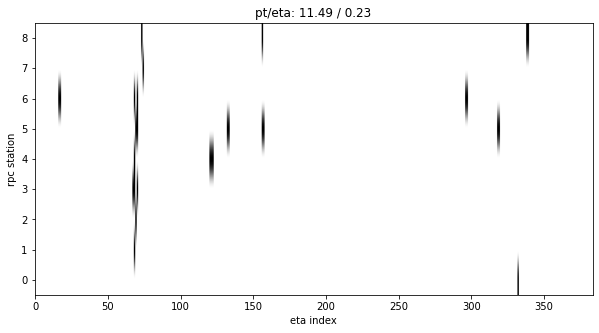

In [8]:
# esempio immagine (un muone con pt=11.5 GeV e pseudorapidità 0.23 + hit di rumore)
idx=1
plt.figure(figsize=(10,5))
plt.imshow(train_images[idx], origin='lower', aspect='auto', cmap='binary')
plt.xlabel('eta index')
plt.ylabel('rpc station')
_ = plt.title('pt/eta: '+str(round(train_labels[idx,0],2))+" / "+str(round(train_labels[idx,1],2)))

In [9]:
# normalizziamo i target in modo che siano entrambi compresi tra 0 e 1
# NOTA: in questo esempio specifico non è necessario normalizzare i vettori delle immagini ad avere valori in [0,1] o con media=0 e sdev=1, perché le immagini
# sono di tipo binario (i pixel hanno solo valori 0 o 1)
scaler = MinMaxScaler()

scaler.fit(train_labels)
train_labels = scaler.transform(train_labels)
test_labels = scaler.transform(test_labels)

# reshape delle immagini nel formato richiesto da keras
train_images = train_images.reshape((train_images.shape[0], 9, 384,1))
test_images = test_images.reshape((test_images.shape[0], 9, 384,1))

# conversione dei valori degli array a float32 come richiesto da keras
train_images = train_images.astype('float32')
train_labels = train_labels.astype('float32')
test_images = test_images.astype('float32')
test_labels = test_labels.astype('float32')

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(47952, 9, 384, 1)
(47952, 2)
(90575, 9, 384, 1)
(90575, 2)


In [12]:
# Modello Teacher: VGG full fledged con ~33k parametri trainabili
kernel = (3,3)
n_filter1 = 16
n_filter2 = 30
n_dense = 50


# modello funzionale
inputs = Input(train_images[0].shape, name = 'input')

# primo blocco convoluzionale (4 convoluzioni 2D con attivazione relu + average pooling finale 
# NOTA: usiamo padding='same' nelle convoluzioni e utilizziamo stariding + pooling per il downsampling dell'output
x = Conv2D(n_filter1, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv1a')(inputs) 
x = Conv2D(n_filter1, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv1b')(x) 
x = Conv2D(n_filter1, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv1c')(x) 
x = AveragePooling2D((1,2))(x)

# seconod blocco convoluzionale 
x = Conv2D(n_filter2, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv2a')(x) 
x = Conv2D(n_filter2, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv2b')(x) 
x = Conv2D(n_filter2, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Conv2c')(x)  
x = AveragePooling2D((3,3))(x)

# flatten layer per adattare l'uscita dell'ultima convoluzione al blocco fully connected usato per la task di regressione
x = Flatten()(x)

# fully connected block
x = Dense(n_dense, activation = 'relu', name = 'Dense1')(x)
x = Dense(n_dense, activation = 'relu', name = 'Dense2')(x)

# output lineare, dimensione 2 (pt, eta)
x = Dense(2, name = 'Output')(x)

# modello finale
teacher = keras.Model(inputs=[inputs], outputs=[x])
teacher.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9, 384, 1)]       0         
                                                                 
 Conv1a (Conv2D)             (None, 9, 192, 16)        160       
                                                                 
 Conv1b (Conv2D)             (None, 9, 96, 16)         2320      
                                                                 
 Conv1c (Conv2D)             (None, 9, 48, 16)         2320      
                                                                 
 average_pooling2d_2 (Averag  (None, 9, 24, 16)        0         
 ePooling2D)                                                     
                                                                 
 Conv2a (Conv2D)             (None, 9, 12, 30)         4350      
                                                           

In [13]:
# Compilazione e training del modello teacher

teacher.compile(optimizer='adam',loss='mse' ,metrics=['mse','mae'])

# early stopping e model checkpoints
callbacks = [keras.callbacks.EarlyStopping(monitor='val_mse', patience=2, min_delta = 0.00001, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint(filepath='teacher_best', monitor='val_mse', verbose=1, save_best_only=True, save_freq='epoch'),]

history = teacher.fit(train_images, train_labels, epochs=50, batch_size=100, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
384/384 [==============================] - ETA: 0s - loss: 0.0665 - mse: 0.0665 - mae: 0.1986
Epoch 1: val_mse improved from inf to 0.02343, saving model to teacher_best


384/384 [==============================] - 9s 22ms/step - loss: 0.0665 - mse: 0.0665 - mae: 0.1986 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1079
Epoch 2/50
382/384 [============================>.] - ETA: 0s - loss: 0.0190 - mse: 0.0190 - mae: 0.0932
Epoch 2: val_mse improved from 0.02343 to 0.01671, saving model to teacher_best


384/384 [==============================] - 6s 16ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.0932 - val_loss: 0.0167 - val_mse: 0.0167 - val_mae: 0.0880
Epoch 3/50
383/384 [============================>.] - ETA: 0s - loss: 0.0149 - mse: 0.0149 - mae: 0.0813
Epoch 3: val_mse improved from 0.01671 to 0.01394, saving model to teacher_best


384/384 [==============================] - 5s 14ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0812 - val_loss: 0.0139 - val_mse: 0.0139 - val_mae: 0.0755
Epoch 4/50
383/384 [============================>.] - ETA: 0s - loss: 0.0129 - mse: 0.0129 - mae: 0.0755
Epoch 4: val_mse improved from 0.01394 to 0.01218, saving model to teacher_best


384/384 [==============================] - 6s 17ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0755 - val_loss: 0.0122 - val_mse: 0.0122 - val_mae: 0.0712
Epoch 5/50
380/384 [============================>.] - ETA: 0s - loss: 0.0116 - mse: 0.0116 - mae: 0.0707
Epoch 5: val_mse improved from 0.01218 to 0.01119, saving model to teacher_best


384/384 [==============================] - 7s 17ms/step - loss: 0.0116 - mse: 0.0116 - mae: 0.0707 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0697
Epoch 6/50
383/384 [============================>.] - ETA: 0s - loss: 0.0107 - mse: 0.0107 - mae: 0.0673
Epoch 6: val_mse did not improve from 0.01119
384/384 [==============================] - 6s 16ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0673 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0735
Epoch 7/50
381/384 [============================>.] - ETA: 0s - loss: 0.0102 - mse: 0.0102 - mae: 0.0659
Epoch 7: val_mse improved from 0.01119 to 0.01014, saving model to teacher_best


384/384 [==============================] - 6s 16ms/step - loss: 0.0102 - mse: 0.0102 - mae: 0.0659 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0645
Epoch 8/50
383/384 [============================>.] - ETA: 0s - loss: 0.0098 - mse: 0.0098 - mae: 0.0646
Epoch 8: val_mse improved from 0.01014 to 0.01011, saving model to teacher_best


384/384 [==============================] - 6s 17ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0646 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0643
Epoch 9/50
384/384 [==============================] - ETA: 0s - loss: 0.0093 - mse: 0.0093 - mae: 0.0624
Epoch 9: val_mse improved from 0.01011 to 0.00998, saving model to teacher_best


384/384 [==============================] - 6s 17ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0624 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0660
Epoch 10/50
383/384 [============================>.] - ETA: 0s - loss: 0.0091 - mse: 0.0091 - mae: 0.0620
Epoch 10: val_mse improved from 0.00998 to 0.00970, saving model to teacher_best


384/384 [==============================] - 7s 17ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0620 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0645
Epoch 11/50
380/384 [============================>.] - ETA: 0s - loss: 0.0088 - mse: 0.0088 - mae: 0.0605
Epoch 11: val_mse did not improve from 0.00970
384/384 [==============================] - 5s 13ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0605 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0622
Epoch 12/50
382/384 [============================>.] - ETA: 0s - loss: 0.0086 - mse: 0.0086 - mae: 0.0598
Epoch 12: val_mse did not improve from 0.00970
384/384 [==============================] - 5s 13ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0598 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0631


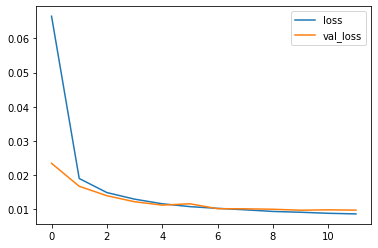

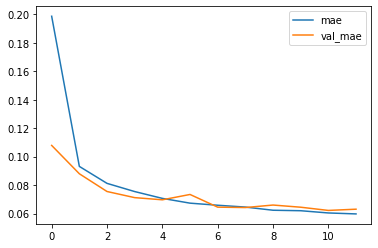

In [14]:
# plot loss e mae vs epoca di training

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.legend()
plt.show()

In [19]:
# carica il best model e calcola predizioni sul test set
teacher = keras.models.load_model('teacher_best')

predictions = scaler.inverse_transform(teacher.predict(test_images))

2831/2831 [==============================] - 8s 3ms/step


<ipython-input-20-c404ff68c58f>:12: RuntimeWarning: invalid value encountered in true_divide
  eff = numer/denum


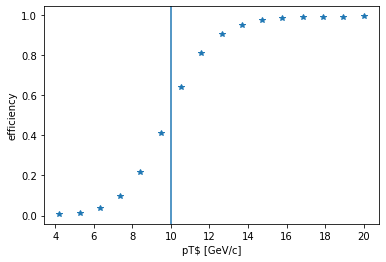

In [20]:
# Turnon curva di efficienza del trigger in funzione del pt

# modo facile per ottenerlo: creare due histogrammi uno con la distribuzione di pt per gli eventi che passono il taglio 
# pt_predetto > soglia e uno con la distribuzione di tutti gli eventi e poi fare il rapporto tra i due istogrammi

predictions = predictions[:,0]
pttrue = scaler.inverse_transform(test_labels)[:,0]
soglia = 10.0 #soglia nominale di trigger Pt>10 GeV/c
numer,_ = np.histogram(pttrue[predictions>soglia], bins=20, range=(0.,20.))
denum,_ = np.histogram(pttrue, bins=20, range=(0.,20.))

eff = numer/denum
lrvalues = np.linspace(0.,20.,20)

_ = plt.plot(lrvalues,eff, '*')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("pT$ [GeV/c]")
_ = plt.ylabel("efficiency")

In [21]:
# Modello Student: Simile al Teacher ma con molti meno parametri (~1k parametri trainabili)
kernel = (3,3)
n_dense = 10

inputs = Input(train_images[0].shape, name = 'input')

x = Conv2D(1, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv1a')(inputs) 
x = Conv2D(2, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv1b')(x) 
x = Conv2D(2, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv1c')(x) 
x = AveragePooling2D((1,2))(x)

x = Conv2D(8, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv2a')(x) 
x = Conv2D(4, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv2b')(x) 
x = Conv2D(8, kernel, strides=(1,2), activation = 'relu', padding = 'same', name = 'Student_Conv2c')(x) 
x = AveragePooling2D((3,3))(x)

x = Flatten()(x) 
x = Dense(n_dense, activation = 'relu', name = 'Student_Dense1')(x)
x = Dense(n_dense, activation = 'relu', name = 'Student_Dense2')(x)

x = Dense(2, name = 'Student_Output')(x)

# modello finale
student = keras.Model(inputs=[inputs], outputs=[x])
student.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9, 384, 1)]       0         
                                                                 
 Student_Conv1a (Conv2D)     (None, 9, 192, 1)         10        
                                                                 
 Student_Conv1b (Conv2D)     (None, 9, 96, 2)          20        
                                                                 
 Student_Conv1c (Conv2D)     (None, 9, 48, 2)          38        
                                                                 
 average_pooling2d_4 (Averag  (None, 9, 24, 2)         0         
 ePooling2D)                                                     
                                                                 
 Student_Conv2a (Conv2D)     (None, 9, 12, 8)          152       
                                                           

In [22]:
# Compilazione e training del modello student

student.compile(optimizer='adam',loss='mse' ,metrics=['mse'])

# early stopping e model checkpoints
callbacks = [keras.callbacks.EarlyStopping(monitor='val_mse', patience=2, min_delta = 0.00001, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint(filepath='student_best', monitor='val_mse', verbose=1, save_best_only=True, save_freq='epoch'),]

history = student.fit(train_images, train_labels, epochs=50, batch_size=100, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
384/384 [==============================] - ETA: 0s - loss: 0.0892 - mse: 0.0892
Epoch 1: val_mse improved from inf to 0.06466, saving model to student_best


384/384 [==============================] - 6s 14ms/step - loss: 0.0892 - mse: 0.0892 - val_loss: 0.0647 - val_mse: 0.0647
Epoch 2/50
380/384 [============================>.] - ETA: 0s - loss: 0.0543 - mse: 0.0543
Epoch 2: val_mse improved from 0.06466 to 0.04950, saving model to student_best


384/384 [==============================] - 5s 12ms/step - loss: 0.0543 - mse: 0.0543 - val_loss: 0.0495 - val_mse: 0.0495
Epoch 3/50
382/384 [============================>.] - ETA: 0s - loss: 0.0474 - mse: 0.0474
Epoch 3: val_mse improved from 0.04950 to 0.04535, saving model to student_best


384/384 [==============================] - 5s 14ms/step - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 4/50
384/384 [==============================] - ETA: 0s - loss: 0.0440 - mse: 0.0440
Epoch 4: val_mse improved from 0.04535 to 0.04271, saving model to student_best


384/384 [==============================] - 5s 12ms/step - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 5/50
377/384 [============================>.] - ETA: 0s - loss: 0.0424 - mse: 0.0424
Epoch 5: val_mse improved from 0.04271 to 0.04231, saving model to student_best


384/384 [==============================] - 5s 12ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0423 - val_mse: 0.0423
Epoch 6/50
382/384 [============================>.] - ETA: 0s - loss: 0.0413 - mse: 0.0413
Epoch 6: val_mse improved from 0.04231 to 0.03981, saving model to student_best


384/384 [==============================] - 4s 11ms/step - loss: 0.0413 - mse: 0.0413 - val_loss: 0.0398 - val_mse: 0.0398
Epoch 7/50
380/384 [============================>.] - ETA: 0s - loss: 0.0384 - mse: 0.0384
Epoch 7: val_mse improved from 0.03981 to 0.03551, saving model to student_best


384/384 [==============================] - 5s 12ms/step - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 8/50
384/384 [==============================] - ETA: 0s - loss: 0.0328 - mse: 0.0328
Epoch 8: val_mse improved from 0.03551 to 0.03002, saving model to student_best


384/384 [==============================] - 4s 11ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 9/50
377/384 [============================>.] - ETA: 0s - loss: 0.0284 - mse: 0.0284
Epoch 9: val_mse improved from 0.03002 to 0.02669, saving model to student_best


384/384 [==============================] - 5s 12ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 10/50
381/384 [============================>.] - ETA: 0s - loss: 0.0259 - mse: 0.0259
Epoch 10: val_mse improved from 0.02669 to 0.02491, saving model to student_best


384/384 [==============================] - 4s 11ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 11/50
380/384 [============================>.] - ETA: 0s - loss: 0.0246 - mse: 0.0246
Epoch 11: val_mse improved from 0.02491 to 0.02361, saving model to student_best


384/384 [==============================] - 5s 12ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 12/50
381/384 [============================>.] - ETA: 0s - loss: 0.0236 - mse: 0.0236
Epoch 12: val_mse improved from 0.02361 to 0.02295, saving model to student_best


384/384 [==============================] - 5s 13ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 13/50
382/384 [============================>.] - ETA: 0s - loss: 0.0231 - mse: 0.0231
Epoch 13: val_mse did not improve from 0.02295
384/384 [==============================] - 3s 8ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 14/50
378/384 [============================>.] - ETA: 0s - loss: 0.0225 - mse: 0.0225
Epoch 14: val_mse improved from 0.02295 to 0.02198, saving model to student_best


384/384 [==============================] - 5s 13ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 15/50
377/384 [============================>.] - ETA: 0s - loss: 0.0221 - mse: 0.0221
Epoch 15: val_mse improved from 0.02198 to 0.02155, saving model to student_best


384/384 [==============================] - 5s 12ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 16/50
383/384 [============================>.] - ETA: 0s - loss: 0.0216 - mse: 0.0216
Epoch 16: val_mse improved from 0.02155 to 0.02118, saving model to student_best


384/384 [==============================] - 4s 12ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 17/50
378/384 [============================>.] - ETA: 0s - loss: 0.0213 - mse: 0.0213
Epoch 17: val_mse improved from 0.02118 to 0.02105, saving model to student_best


384/384 [==============================] - 4s 12ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 18/50
378/384 [============================>.] - ETA: 0s - loss: 0.0210 - mse: 0.0210
Epoch 18: val_mse improved from 0.02105 to 0.02057, saving model to student_best


384/384 [==============================] - 4s 12ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 19/50
384/384 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0208
Epoch 19: val_mse improved from 0.02057 to 0.02050, saving model to student_best


384/384 [==============================] - 5s 12ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 20/50
378/384 [============================>.] - ETA: 0s - loss: 0.0204 - mse: 0.0204
Epoch 20: val_mse improved from 0.02050 to 0.02033, saving model to student_best


384/384 [==============================] - 4s 11ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 21/50
378/384 [============================>.] - ETA: 0s - loss: 0.0203 - mse: 0.0203
Epoch 21: val_mse improved from 0.02033 to 0.01975, saving model to student_best


384/384 [==============================] - 6s 16ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 22/50
381/384 [============================>.] - ETA: 0s - loss: 0.0201 - mse: 0.0201
Epoch 22: val_mse did not improve from 0.01975
384/384 [==============================] - 3s 9ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0202 - val_mse: 0.0202
Epoch 23/50
379/384 [============================>.] - ETA: 0s - loss: 0.0200 - mse: 0.0200
Epoch 23: val_mse improved from 0.01975 to 0.01957, saving model to student_best


384/384 [==============================] - 4s 11ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 24/50
381/384 [============================>.] - ETA: 0s - loss: 0.0197 - mse: 0.0197
Epoch 24: val_mse improved from 0.01957 to 0.01944, saving model to student_best


384/384 [==============================] - 5s 13ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 25/50
379/384 [============================>.] - ETA: 0s - loss: 0.0197 - mse: 0.0197
Epoch 25: val_mse did not improve from 0.01944
384/384 [==============================] - 3s 8ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 26/50
382/384 [============================>.] - ETA: 0s - loss: 0.0194 - mse: 0.0194
Epoch 26: val_mse improved from 0.01944 to 0.01929, saving model to student_best


384/384 [==============================] - 4s 11ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 27/50
382/384 [============================>.] - ETA: 0s - loss: 0.0193 - mse: 0.0193
Epoch 27: val_mse improved from 0.01929 to 0.01885, saving model to student_best


384/384 [==============================] - 5s 12ms/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 28/50
378/384 [============================>.] - ETA: 0s - loss: 0.0192 - mse: 0.0192
Epoch 28: val_mse did not improve from 0.01885
384/384 [==============================] - 3s 9ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 29/50
377/384 [============================>.] - ETA: 0s - loss: 0.0192 - mse: 0.0192
Epoch 29: val_mse did not improve from 0.01885
384/384 [==============================] - 3s 8ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0193 - val_mse: 0.0193


In [23]:
# carica il best model e calcola predizioni sul test set
student = keras.models.load_model('student_best')

predictions_s = scaler.inverse_transform(student.predict(test_images))

2831/2831 [==============================] - 10s 3ms/step


<ipython-input-24-4185e6809ec9>:12: RuntimeWarning: invalid value encountered in true_divide
  eff_s = numer_s/denum_s


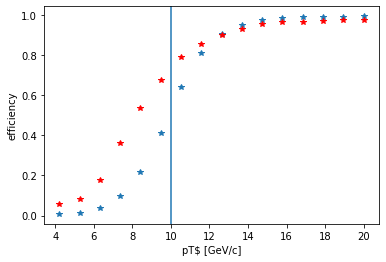

In [24]:
# Turnon curva di efficienza del trigger in funzione del pt

# modo facile per ottenerlo: creare due histogrammi uno con la distribuzione di pt per gli eventi che passono il taglio 
# pt_predetto > soglia e uno con la distribuzione di tutti gli eventi e poi fare il rapporto tra i due istogrammi

predictions_s = predictions_s[:,0]
pttrue = scaler.inverse_transform(test_labels)[:,0]
soglia = 10.0 #soglia nominale di trigger Pt>10 GeV/c
numer_s,_ = np.histogram(pttrue[predictions_s>soglia], bins=20, range=(0.,20.))
denum_s,_ = np.histogram(pttrue, bins=20, range=(0.,20.))

eff_s = numer_s/denum_s
lrvalues = np.linspace(0.,20.,20)

_ = plt.plot(lrvalues,eff, '*')
_ = plt.plot(lrvalues,eff_s, 'r*')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("pT$ [GeV/c]")
_ = plt.ylabel("efficiency")

NOTA: lo student f32 anche se con soli 1k parametri non può essere implementato su una FPGA Xilinx UltraScale+ xcvu13p anche se è una delle più grandi e costose disponibili oggi ...

È necessario quantizzare in modo spinto il modello.

In [25]:
# Studente quantizzato fixed-point a 4 bit con libreria Qkeras
# l'output layer non viene quantizzato

kernel = (3,3)
n_dense = 10

sym = 1
myalpha = None
nbits = 4

inputs = Input(train_images[0].shape, name = 'input')

# quantized_bits( bits: number of bits to perform quantization, 
#                 integer: number of bits to the left of the decimal point.
#                 symmetric: if true, we will have the same number of values for positive and negative numbers.
#                 alpha: a tensor or None, the scaling factor per channel. If None, the scaling factor is 1 for all channels.

x = QConv2D(1, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv1a')(inputs) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(2, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv1b')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QConv2D(2, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv1c')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QAveragePooling2D(pool_size=(1,2), activation='quantized_relu('+str(nbits)+')')(x)

x = QConv2D(8, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv2a')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(4, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv2b')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(8, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Qstudent_Conv2c')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QAveragePooling2D(pool_size=(3,3), activation='quantized_relu('+str(nbits)+')')(x)

x = Flatten()(x) 
x = QDense(n_dense, kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
           bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), name = 'Qstudent_Dense1')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QDense(n_dense, kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
           bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), name = 'Qstudent_Dense2')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
    
x = Dense(2, name = 'Output')(x)

qstudent = keras.Model(inputs=[inputs], outputs=[x])
qstudent.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9, 384, 1)]       0         
                                                                 
 Qstudent_Conv1a (QConv2D)   (None, 9, 192, 1)         10        
                                                                 
 q_activation (QActivation)  (None, 9, 192, 1)         0         
                                                                 
 Qstudent_Conv1b (QConv2D)   (None, 9, 96, 2)          20        
                                                                 
 q_activation_1 (QActivation  (None, 9, 96, 2)         0         
 )                                                               
                                                                 
 Qstudent_Conv1c (QConv2D)   (None, 9, 48, 2)          38        
                                                           

In [26]:
# Compilazione e training del modello Qstudent

qstudent.compile(optimizer='adam',loss='mse' ,metrics=['mse'])

# early stopping e model checkpoints
callbacks = [keras.callbacks.EarlyStopping(monitor='val_mse', patience=2, min_delta = 0.00001, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint(filepath='qstudent_best', monitor='val_mse', verbose=1, save_best_only=True, save_freq='epoch'),]

history = qstudent.fit(train_images, train_labels, epochs=50, batch_size=100, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
384/384 [==============================] - ETA: 0s - loss: 0.1072 - mse: 0.1072
Epoch 1: val_mse improved from inf to 0.07730, saving model to qstudent_best


384/384 [==============================] - 25s 53ms/step - loss: 0.1072 - mse: 0.1072 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 2/50
384/384 [==============================] - ETA: 0s - loss: 0.0776 - mse: 0.0776
Epoch 2: val_mse improved from 0.07730 to 0.07725, saving model to qstudent_best


384/384 [==============================] - 17s 43ms/step - loss: 0.0776 - mse: 0.0776 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 3/50
381/384 [============================>.] - ETA: 0s - loss: 0.0778 - mse: 0.0778
Epoch 3: val_mse improved from 0.07725 to 0.07684, saving model to qstudent_best


384/384 [==============================] - 17s 45ms/step - loss: 0.0778 - mse: 0.0778 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 4/50
384/384 [==============================] - ETA: 0s - loss: 0.0775 - mse: 0.0775
Epoch 4: val_mse did not improve from 0.07684
384/384 [==============================] - 6s 16ms/step - loss: 0.0775 - mse: 0.0775 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 5/50
383/384 [============================>.] - ETA: 0s - loss: 0.0775 - mse: 0.0775
Epoch 5: val_mse did not improve from 0.07684
384/384 [==============================] - 6s 16ms/step - loss: 0.0775 - mse: 0.0775 - val_loss: 0.0772 - val_mse: 0.0772


In [27]:
# carica il best model e clacola le predizioni sul test set
qstudent = keras.models.load_model('qstudent_best')

predictions_qs = scaler.inverse_transform(qstudent.predict(test_images))


2831/2831 [==============================] - 26s 9ms/step


<ipython-input-28-a3677b579298>:12: RuntimeWarning: invalid value encountered in true_divide
  eff_qs = numer_qs/denum_qs


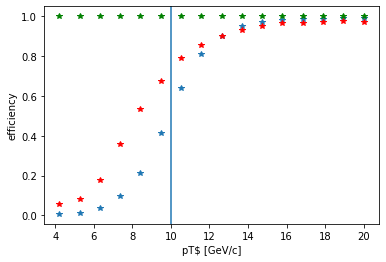

In [28]:
# Turnon curva di efficienza del trigger in funzione del pt

# modo facile per ottenerlo: creare due histogrammi uno con la distribuzione di pt per gli eventi che passono il taglio 
# pt_predetto > soglia e uno con la distribuzione di tutti gli eventi e poi fare il rapporto tra i due istogrammi

predictions_qs = predictions_qs[:,0]
pttrue = scaler.inverse_transform(test_labels)[:,0]
soglia = 10.0 #soglia nominale di trigger Pt>10 GeV/c
numer_qs,_ = np.histogram(pttrue[predictions_qs>soglia], bins=20, range=(0.,20.))
denum_qs,_ = np.histogram(pttrue, bins=20, range=(0.,20.))

eff_qs = numer_qs/denum_qs
lrvalues = np.linspace(0.,20.,20)

_ = plt.plot(lrvalues,eff, '*')
_ = plt.plot(lrvalues,eff_s, 'r*')
_ = plt.plot(lrvalues,eff_qs, 'g*')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("pT$ [GeV/c]")
_ = plt.ylabel("efficiency")

In [ ]:
# la rete quantizzata non funziona ... cerchiamo di ri-addestrarla usando teacher-student knowledge-transfer

In [29]:
# Studente (float) adestrato con knoweldge distillation


# Classe custom Layer per la HintLoss
class HintLossLayer(tf.keras.layers.Layer):
    def __init__(self, gamma=0.2, name = "name", mname = "hint"):
        super(HintLossLayer, self).__init__(name = name)
        self.gamma = gamma
        self.mname = mname
    def call(self, inputs):
        self.add_loss(tf.reduce_mean(tf.square(inputs[1]- inputs[2])) * self.gamma)
        self.add_metric(tf.reduce_mean((tf.square(inputs[1]- inputs[2]))) * self.gamma, name = self.mname, aggregation="mean")
        return inputs[0]
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'gamma': self.gamma
        })
        return config


# Classe custom Model per la distillazione 
act = "relu"
d = 0.2
class CustomModel(keras.Model):
    def train_step(self, data):
        
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data   

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass

            stud = tf.reduce_mean(tf.square(y_pred[0]-y))
            teach = tf.reduce_mean(tf.square(y_pred[1]-y))
            f0 = lambda: tf.constant(0.)
            f1 = lambda: tf.constant(1.)
            w = tf.case([(tf.less(teach, stud), f1)], default=f0)
            loss = self.compiled_loss(y, y_pred[0], regularization_losses= [w*l for l in self.losses])

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [34]:
# Modello Student distillato: Student di prima con adaptation layers

dictionary = {'33k': {'pad1_tuple': (0,12), 'block1': 'Conv1c', 'conv2_filter': 30, 'block2': 'Conv2c', 
                      'pad2_tuple': (3,1), 'dense': 50}}
teach_name = '33k'
key = list(dictionary[teach_name].keys())
print(key)

key = list(dictionary[teach_name].keys())
pad1_tuple = dictionary[teach_name][key[0]]
block1 = dictionary[teach_name][key[1]]
conv2_filter = dictionary[teach_name][key[2]]
block2 = dictionary[teach_name][key[3]]
pad2_tuple = dictionary[teach_name][key[4]]
dense = dictionary[teach_name][key[5]]

nbits = 4
avebits = 4

kernel = (3,3)
n_dense = 10
sym = 1
myalpha = None

gamma1=1.0
gamma2=0.01
gamma3=0.1

teacher = keras.models.load_model('teacher_best')
for i in range(len(teacher.layers)):
    teacher.layers[i].trainable = False
    if "Dropout" in teacher.layers[i].name:
        teacher.layers[i].rate = 0
        print(teacher.layers[i].rate)


inputs = Input(train_images[0].shape, name = 'Student_input')

x = QConv2D(1, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv1a')(inputs) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(2, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv1b')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QConv2D(2, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha), 
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv1c')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x)
x = QAveragePooling2D(pool_size=(1,2), activation='quantized_relu('+str(avebits)+')')(x)
padding1 = tf.keras.layers.ZeroPadding2D(pad1_tuple)(x)
Adap1 = Conv2D(1, (1,1), activation = 'relu', padding = 'same', name = 'Student_Adap1')(padding1)
hint1 = HintLossLayer(gamma = gamma1, name = 'Hint1', mname = 'Hint1')([x, Adap1, teacher.get_layer(block1).output])

x = QConv2D(8, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv2a')(hint1) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(4, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv2b')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QConv2D(8, kernel, strides=(1,2), kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
            bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), padding = 'same', name = 'Student_Conv2c')(x) 
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QAveragePooling2D(pool_size=(3,3), activation='quantized_relu('+str(avebits)+')')(x)
padding2 = tf.keras.layers.ZeroPadding2D(pad2_tuple)(x)
Adap2 = Conv2D(conv2_filter, (1,1), activation = 'relu', padding = 'same', name = 'Student_Adap2')(padding2)
hint2 = HintLossLayer(gamma = gamma2, name = 'Hint2', mname = 'Hint2')([x, Adap2, teacher.get_layer(block2).output])

x = Flatten()(hint2)
x = QDense(n_dense, kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
           bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), name = 'Student_Dense1')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x) 
x = QDense(n_dense, kernel_quantizer = quantized_bits(nbits,0,sym,alpha=myalpha),
           bias_quantizer = quantized_bits(nbits,0,1,alpha=myalpha), name = 'Student_Dense2')(x)
x = QActivation('quantized_relu('+str(nbits)+')')(x)
Adap3 = Dense(dense, activation = 'relu', name = 'Student_Adap3')(x)
hint3 = HintLossLayer(gamma = gamma3, name = 'Hint3', mname = 'Hint3')([x, Adap3, teacher.get_layer('Dense2').output])

x = Dense(2, name = 'Student_Output')(hint3) 

# modello finale
qstudent_dist = CustomModel(inputs=[inputs, teacher.layers[0].input], outputs=[x, teacher.layers[-1].output])
qstudent_dist.summary()

['pad1_tuple', 'block1', 'conv2_filter', 'block2', 'pad2_tuple', 'dense']
Model: "custom_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Student_input (InputLayer)     [(None, 9, 384, 1)]  0           []                               
                                                                                                  
 Student_Conv1a (QConv2D)       (None, 9, 192, 1)    10          ['Student_input[0][0]']          
                                                                                                  
 q_activation_16 (QActivation)  (None, 9, 192, 1)    0           ['Student_Conv1a[0][0]']         
                                                                                                  
 Student_Conv1b (QConv2D)       (None, 9, 96, 2)     20          ['q_activation_16[0][0]']        
           

In [35]:
# compilazione e training
import gc
class GarbageCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

qstudent_dist.compile(optimizer='adam',loss='mse' ,metrics=['mse'])

# early stopping e model checkpoints
callbacks = [keras.callbacks.EarlyStopping(monitor='val_Student_Output_mse', patience=5, min_delta = 0.00001, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint(filepath='qstudent_dist_best', monitor='val_Student_Output_mse', verbose=1, save_best_only=True, save_freq='epoch'),
             GarbageCallback()]

history = qstudent_dist.fit([train_images, train_images], [train_labels,train_labels], epochs=50, batch_size=64, validation_split=0.2, callbacks=callbacks)



Epoch 1/50
600/600 [==============================] - ETA: 0s - loss: 0.1435 - Student_Output_loss: 0.1399 - Student_Output_mse: 0.1399 - Output_mse: 0.0086 - Hint1: 0.0020 - Hint2: 5.0503e-04 - Hint3: 0.0011
Epoch 1: val_Student_Output_mse improved from inf to 0.07722, saving model to qstudent_dist_best


600/600 [==============================] - 38s 50ms/step - loss: 0.1435 - Student_Output_loss: 0.1399 - Student_Output_mse: 0.1399 - Output_mse: 0.0086 - Hint1: 0.0020 - Hint2: 5.0503e-04 - Hint3: 0.0011 - val_loss: 0.0804 - val_Student_Output_loss: 0.0772 - val_Student_Output_mse: 0.0772 - val_Output_mse: 0.0097 - val_Hint1: 0.0018 - val_Hint2: 4.8090e-04 - val_Hint3: 9.1162e-04
Epoch 2/50
599/600 [============================>.] - ETA: 0s - loss: 0.0794 - Student_Output_loss: 0.0763 - Student_Output_mse: 0.0763 - Output_mse: 0.0086 - Hint1: 0.0018 - Hint2: 4.7478e-04 - Hint3: 8.9922e-04
Epoch 2: val_Student_Output_mse improved from 0.07722 to 0.07318, saving model to qstudent_dist_best


600/600 [==============================] - 32s 53ms/step - loss: 0.0794 - Student_Output_loss: 0.0763 - Student_Output_mse: 0.0763 - Output_mse: 0.0086 - Hint1: 0.0018 - Hint2: 4.7464e-04 - Hint3: 8.9900e-04 - val_loss: 0.0763 - val_Student_Output_loss: 0.0732 - val_Student_Output_mse: 0.0732 - val_Output_mse: 0.0097 - val_Hint1: 0.0018 - val_Hint2: 4.7827e-04 - val_Hint3: 8.8297e-04
Epoch 3/50
600/600 [==============================] - ETA: 0s - loss: 0.0650 - Student_Output_loss: 0.0621 - Student_Output_mse: 0.0621 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.6880e-04 - Hint3: 6.8411e-04
Epoch 3: val_Student_Output_mse improved from 0.07318 to 0.04248, saving model to qstudent_dist_best


600/600 [==============================] - 27s 44ms/step - loss: 0.0650 - Student_Output_loss: 0.0621 - Student_Output_mse: 0.0621 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.6880e-04 - Hint3: 6.8411e-04 - val_loss: 0.0450 - val_Student_Output_loss: 0.0425 - val_Student_Output_mse: 0.0425 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 - val_Hint2: 4.6790e-04 - val_Hint3: 3.1875e-04
Epoch 4/50
598/600 [============================>.] - ETA: 0s - loss: 0.0432 - Student_Output_loss: 0.0407 - Student_Output_mse: 0.0407 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.5798e-04 - Hint3: 2.9511e-04
Epoch 4: val_Student_Output_mse improved from 0.04248 to 0.03921, saving model to qstudent_dist_best


600/600 [==============================] - 26s 43ms/step - loss: 0.0432 - Student_Output_loss: 0.0407 - Student_Output_mse: 0.0407 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.5781e-04 - Hint3: 2.9506e-04 - val_loss: 0.0417 - val_Student_Output_loss: 0.0392 - val_Student_Output_mse: 0.0392 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 - val_Hint2: 4.5931e-04 - val_Hint3: 2.7729e-04
Epoch 5/50
600/600 [==============================] - ETA: 0s - loss: 0.0402 - Student_Output_loss: 0.0377 - Student_Output_mse: 0.0377 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.5134e-04 - Hint3: 2.7312e-04
Epoch 5: val_Student_Output_mse improved from 0.03921 to 0.03396, saving model to qstudent_dist_best


600/600 [==============================] - 26s 43ms/step - loss: 0.0402 - Student_Output_loss: 0.0377 - Student_Output_mse: 0.0377 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.5134e-04 - Hint3: 2.7312e-04 - val_loss: 0.0364 - val_Student_Output_loss: 0.0340 - val_Student_Output_mse: 0.0340 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 - val_Hint2: 4.5414e-04 - val_Hint3: 2.5596e-04
Epoch 6/50
598/600 [============================>.] - ETA: 0s - loss: 0.0388 - Student_Output_loss: 0.0364 - Student_Output_mse: 0.0364 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.4641e-04 - Hint3: 2.6473e-04
Epoch 6: val_Student_Output_mse did not improve from 0.03396
600/600 [==============================] - 13s 21ms/step - loss: 0.0388 - Student_Output_loss: 0.0364 - Student_Output_mse: 0.0364 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.4649e-04 - Hint3: 2.6490e-04 - val_loss: 0.0407 - val_Student_Output_loss: 0.0382 - val_Student_Output_mse: 0.0382 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 

600/600 [==============================] - 25s 41ms/step - loss: 0.0367 - Student_Output_loss: 0.0343 - Student_Output_mse: 0.0343 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.4332e-04 - Hint3: 2.5293e-04 - val_loss: 0.0352 - val_Student_Output_loss: 0.0328 - val_Student_Output_mse: 0.0328 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 - val_Hint2: 4.4861e-04 - val_Hint3: 2.4355e-04
Epoch 8/50
599/600 [============================>.] - ETA: 0s - loss: 0.0377 - Student_Output_loss: 0.0353 - Student_Output_mse: 0.0353 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.4154e-04 - Hint3: 2.5762e-04
Epoch 8: val_Student_Output_mse did not improve from 0.03276
600/600 [==============================] - 13s 21ms/step - loss: 0.0377 - Student_Output_loss: 0.0353 - Student_Output_mse: 0.0353 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.4144e-04 - Hint3: 2.5761e-04 - val_loss: 0.0357 - val_Student_Output_loss: 0.0333 - val_Student_Output_mse: 0.0333 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 

600/600 [==============================] - 25s 42ms/step - loss: 0.0358 - Student_Output_loss: 0.0334 - Student_Output_mse: 0.0334 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.4074e-04 - Hint3: 2.4317e-04 - val_loss: 0.0338 - val_Student_Output_loss: 0.0314 - val_Student_Output_mse: 0.0314 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 - val_Hint2: 4.4139e-04 - val_Hint3: 2.3108e-04
Epoch 10/50
599/600 [============================>.] - ETA: 0s - loss: 0.0349 - Student_Output_loss: 0.0325 - Student_Output_mse: 0.0325 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3819e-04 - Hint3: 2.3733e-04
Epoch 10: val_Student_Output_mse improved from 0.03138 to 0.02992, saving model to qstudent_dist_best


600/600 [==============================] - 25s 41ms/step - loss: 0.0349 - Student_Output_loss: 0.0325 - Student_Output_mse: 0.0325 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3832e-04 - Hint3: 2.3732e-04 - val_loss: 0.0323 - val_Student_Output_loss: 0.0299 - val_Student_Output_mse: 0.0299 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 - val_Hint2: 4.4091e-04 - val_Hint3: 2.2900e-04
Epoch 11/50
600/600 [==============================] - ETA: 0s - loss: 0.0344 - Student_Output_loss: 0.0320 - Student_Output_mse: 0.0320 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3818e-04 - Hint3: 2.3517e-04
Epoch 11: val_Student_Output_mse improved from 0.02992 to 0.02943, saving model to qstudent_dist_best


600/600 [==============================] - 25s 42ms/step - loss: 0.0344 - Student_Output_loss: 0.0320 - Student_Output_mse: 0.0320 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3818e-04 - Hint3: 2.3517e-04 - val_loss: 0.0318 - val_Student_Output_loss: 0.0294 - val_Student_Output_mse: 0.0294 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 - val_Hint2: 4.4155e-04 - val_Hint3: 2.1934e-04
Epoch 12/50
600/600 [==============================] - ETA: 0s - loss: 0.0338 - Student_Output_loss: 0.0314 - Student_Output_mse: 0.0314 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3697e-04 - Hint3: 2.3151e-04
Epoch 12: val_Student_Output_mse did not improve from 0.02943
600/600 [==============================] - 13s 21ms/step - loss: 0.0338 - Student_Output_loss: 0.0314 - Student_Output_mse: 0.0314 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3697e-04 - Hint3: 2.3151e-04 - val_loss: 0.0321 - val_Student_Output_loss: 0.0297 - val_Student_Output_mse: 0.0297 - val_Output_mse: 0.0097 - val_Hint1: 0.001

600/600 [==============================] - 25s 41ms/step - loss: 0.0337 - Student_Output_loss: 0.0313 - Student_Output_mse: 0.0313 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3680e-04 - Hint3: 2.3520e-04 - val_loss: 0.0317 - val_Student_Output_loss: 0.0293 - val_Student_Output_mse: 0.0293 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 - val_Hint2: 4.3817e-04 - val_Hint3: 2.2987e-04
Epoch 16/50
600/600 [==============================] - ETA: 0s - loss: 0.0333 - Student_Output_loss: 0.0309 - Student_Output_mse: 0.0309 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3647e-04 - Hint3: 2.3537e-04
Epoch 16: val_Student_Output_mse did not improve from 0.02927
600/600 [==============================] - 13s 21ms/step - loss: 0.0333 - Student_Output_loss: 0.0309 - Student_Output_mse: 0.0309 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3647e-04 - Hint3: 2.3537e-04 - val_loss: 0.0356 - val_Student_Output_loss: 0.0331 - val_Student_Output_mse: 0.0331 - val_Output_mse: 0.0097 - val_Hint1: 0.001

600/600 [==============================] - 25s 42ms/step - loss: 0.0324 - Student_Output_loss: 0.0300 - Student_Output_mse: 0.0300 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3581e-04 - Hint3: 2.3043e-04 - val_loss: 0.0304 - val_Student_Output_loss: 0.0280 - val_Student_Output_mse: 0.0280 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 - val_Hint2: 4.3883e-04 - val_Hint3: 2.1922e-04
Epoch 18/50
597/600 [============================>.] - ETA: 0s - loss: 0.0320 - Student_Output_loss: 0.0296 - Student_Output_mse: 0.0296 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3444e-04 - Hint3: 2.2830e-04
Epoch 18: val_Student_Output_mse did not improve from 0.02805
600/600 [==============================] - 12s 21ms/step - loss: 0.0320 - Student_Output_loss: 0.0296 - Student_Output_mse: 0.0296 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3412e-04 - Hint3: 2.2809e-04 - val_loss: 0.0320 - val_Student_Output_loss: 0.0296 - val_Student_Output_mse: 0.0296 - val_Output_mse: 0.0097 - val_Hint1: 0.001

600/600 [==============================] - 25s 41ms/step - loss: 0.0317 - Student_Output_loss: 0.0293 - Student_Output_mse: 0.0293 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3335e-04 - Hint3: 2.2649e-04 - val_loss: 0.0300 - val_Student_Output_loss: 0.0276 - val_Student_Output_mse: 0.0276 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 - val_Hint2: 4.3730e-04 - val_Hint3: 2.1003e-04
Epoch 20/50
598/600 [============================>.] - ETA: 0s - loss: 0.0314 - Student_Output_loss: 0.0290 - Student_Output_mse: 0.0290 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3407e-04 - Hint3: 2.2583e-04
Epoch 20: val_Student_Output_mse improved from 0.02761 to 0.02596, saving model to qstudent_dist_best


600/600 [==============================] - 25s 41ms/step - loss: 0.0314 - Student_Output_loss: 0.0290 - Student_Output_mse: 0.0290 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3395e-04 - Hint3: 2.2570e-04 - val_loss: 0.0283 - val_Student_Output_loss: 0.0260 - val_Student_Output_mse: 0.0260 - val_Output_mse: 0.0097 - val_Hint1: 0.0017 - val_Hint2: 4.3718e-04 - val_Hint3: 2.0612e-04
Epoch 21/50
598/600 [============================>.] - ETA: 0s - loss: 0.0312 - Student_Output_loss: 0.0288 - Student_Output_mse: 0.0288 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3403e-04 - Hint3: 2.2401e-04
Epoch 21: val_Student_Output_mse did not improve from 0.02596
600/600 [==============================] - 12s 20ms/step - loss: 0.0312 - Student_Output_loss: 0.0288 - Student_Output_mse: 0.0288 - Output_mse: 0.0086 - Hint1: 0.0017 - Hint2: 4.3405e-04 - Hint3: 2.2400e-04 - val_loss: 0.0293 - val_Student_Output_loss: 0.0269 - val_Student_Output_mse: 0.0269 - val_Output_mse: 0.0097 - val_Hint1: 0.001

In [36]:
# carica il best model
qstudent_dist = keras.models.load_model('qstudent_dist_best')

predictions_qs_dist = qstudent_dist.predict([test_images, test_images])[0]
predictions_qs_dist = np.array(predictions_qs_dist)
predictions_qs_dist = scaler.inverse_transform(predictions_qs_dist)

2831/2831 [==============================] - 31s 11ms/step


<ipython-input-37-fda54d6f7636>:12: RuntimeWarning: invalid value encountered in true_divide
  eff_qs_d = numer_qs_d/denum_qs_d


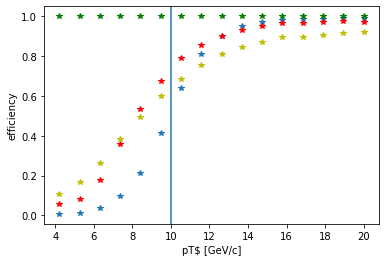

In [37]:
# Turnon curva di efficienza del trigger in funzione del pt

# modo facile per ottenerlo: creare due histogrammi uno con la distribuzione di pt per gli eventi che passono il taglio 
# pt_predetto > soglia e uno con la distribuzione di tutti gli eventi e poi fare il rapporto tra i due istogrammi

predictions_qs_dist = predictions_qs_dist[:,0]
pttrue = scaler.inverse_transform(test_labels)[:,0]
soglia = 10.0 #soglia nominale di trigger Pt>10 GeV/c
numer_qs_d,_ = np.histogram(pttrue[predictions_qs_dist>soglia], bins=20, range=(0.,20.))
denum_qs_d,_ = np.histogram(pttrue, bins=20, range=(0.,20.))

eff_qs_d = numer_qs_d/denum_qs_d
lrvalues = np.linspace(0.,20.,20)

_ = plt.plot(lrvalues,eff, '*')
_ = plt.plot(lrvalues,eff_s, 'r*')
_ = plt.plot(lrvalues,eff_qs, 'g*')
_ = plt.plot(lrvalues,eff_qs_d, 'y*')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("pT$ [GeV/c]")
_ = plt.ylabel("efficiency")

### Traduzione del modello in VHDL via HLS4ML

richiede l'installazione di hls4ml e VivadoHLS, quest'ultimo non possibile su google colab

Per installare HLS4ML è sufficiente il comando:

`pip install hls4ml`

(Al [link](https://fastmachinelearning.org/hls4ml/setup.html) la lista di ulteriori dependencies ed istruzioni aggiuntive)

HLS4ML è testato su Linux, e supporta le versioni di Vivado HLS da 2018.2 a 2020.1. Vitis HLS non è ancora supportato. Windows e macOS non sono supportati.

Per il download e l'installazione di Vivado si rimanda al [link](https://www.xilinx.com/support/download.html)

In [ ]:
NOTA: # solo poche di righe per far vedere il workflow tipico necessario per fare la sintesi del modello 
# NOTA: il modello utilizato sopra con immagini 387x9 e uso di layer QAveragePooling non è supportato al momento da hls4ml
# quindi usiamo un modellino di CNN più semplice che usa un input di dimensione 16x9 per far vedere come funziona la conversione

In [38]:
!pip install hls4ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 295 kB 8.3 MB/s 
     |████████████████████████████████| 13.1 MB 58.0 MB/s 


In [39]:
# funzione per printare il dizionario di descrizione del modello estratto da hls4ml
def print_dict(d, indent=0):
    align=20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

In [48]:
import hls4ml

# CNN semplificata
nbits = 4
sym = 1

model = Sequential()                                                                                                                                                              
model.add(Input((9,16,1), name = 'input_student'))                                                                                                                                
                                                                                                                                                                                  
model.add(QConv2D(1, (3,3), kernel_quantizer = quantized_bits(nbits,0,alpha = sym), bias_quantizer = quantized_bits(nbits,0,alpha = 1),  name = 'Student_Conv1a'))                                                                                                                              
model.add( QActivation('quantized_relu('+str(nbits)+')'))
model.add(QConv2D(1, (3,3), kernel_quantizer = quantized_bits(nbits,0,alpha = sym), bias_quantizer = quantized_bits(nbits,0,alpha = 1),  name = 'Student_Conv1b'))                                                                                                                              
model.add( QActivation('quantized_relu('+str(nbits)+')'))
model.add(QConv2D(6, (3,3), kernel_quantizer = quantized_bits(nbits,0,alpha = sym), bias_quantizer = quantized_bits(nbits,0,1),  name = 'Student_Conv2a'))
model.add(QActivation('quantized_relu('+str(nbits)+')'))
model.add(QConv2D(6, (3,3), kernel_quantizer = quantized_bits(nbits,0, alpha = sym), bias_quantizer = quantized_bits(nbits,0,1),  name = 'Student_Conv2b'))
model.add(QActivation('quantized_relu('+str(nbits)+')'))
model.add(Flatten())
model.add(QDense(10, name='fc1',
                 kernel_quantizer=quantized_bits(nbits,0,alpha=1), bias_quantizer=quantized_bits(nbits,0,alpha=1)))
model.add(QActivation(activation=quantized_relu(nbits), name='relu1'))
model.add(QDense(10, name='fc2',
                 kernel_quantizer=quantized_bits(nbits,0,alpha=1), bias_quantizer=quantized_bits(nbits,0,alpha=1)))
model.add(QActivation(activation=quantized_relu(nbits), name='relu2'))
model.add(Dense(2, name='output'))

model.summary()
model.compile(optimizer="adam", loss=['mse'], metrics=['mse'])



# HLS4ML: estrazione dal modello salvato da tensorflow del dizionario con la descrizione del modello
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

print("-----------------------------------")
print_dict(config)
print("-----------------------------------")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Student_Conv1a (QConv2D)    (None, 7, 14, 1)          10        
                                                                 
 q_activation_28 (QActivatio  (None, 7, 14, 1)         0         
 n)                                                              
                                                                 
 Student_Conv1b (QConv2D)    (None, 5, 12, 1)          10        
                                                                 
 q_activation_29 (QActivatio  (None, 5, 12, 1)         0         
 n)                                                              
                                                                 
 Student_Conv2a (QConv2D)    (None, 3, 10, 6)          60        
                                                                 
 q_activation_30 (QActivatio  (None, 3, 10, 6)        

In [49]:
# parametri per la configurazione della conversione per vivadoHLS

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType']     = 'io_stream' #o io_parallel, l'unico supportato (al momento) per CNN è io_stream
cfg['HLSConfig']  = config
cfg['KerasModel'] = model
cfg['OutputDir']  = 'hls4ml_prj/'
cfg['XilinxPart'] = 'xcvu13p-flga2577-1-e'

In [50]:
hls_model = hls4ml.converters.keras_to_hls(cfg)

Interpreting Sequential
Topology:
Layer name: input_student, layer type: InputLayer, input shapes: [[None, 9, 16, 1]], output shape: [None, 9, 16, 1]
Layer name: Student_Conv1a, layer type: QConv2D, input shapes: [[None, 9, 16, 1]], output shape: [None, 7, 14, 1]
Layer name: q_activation_28, layer type: Activation, input shapes: [[None, 7, 14, 1]], output shape: [None, 7, 14, 1]
Layer name: Student_Conv1b, layer type: QConv2D, input shapes: [[None, 7, 14, 1]], output shape: [None, 5, 12, 1]
Layer name: q_activation_29, layer type: Activation, input shapes: [[None, 5, 12, 1]], output shape: [None, 5, 12, 1]
Layer name: Student_Conv2a, layer type: QConv2D, input shapes: [[None, 5, 12, 1]], output shape: [None, 3, 10, 6]
Layer name: q_activation_30, layer type: Activation, input shapes: [[None, 3, 10, 6]], output shape: [None, 3, 10, 6]
Layer name: Student_Conv2b, layer type: QConv2D, input shapes: [[None, 3, 10, 6]], output shape: [None, 1, 8, 6]
Layer name: q_activation_31, layer type: 

In [51]:
hls_model.compile()

Writing HLS project
Done


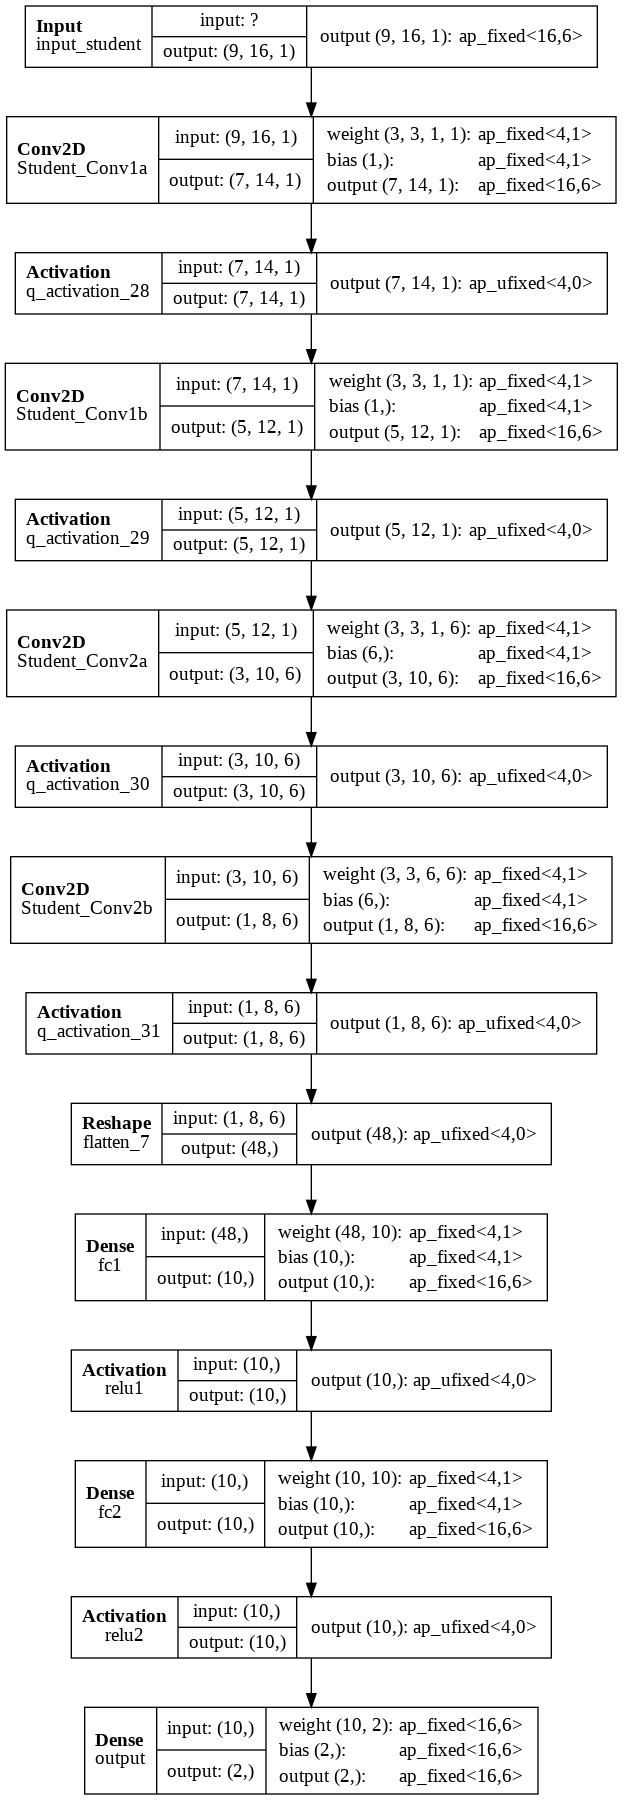

In [52]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Logic syntehsis con VivadoHLS

Richiede l'installazione di VivadoHLS, non disponibile su google colab e in questo tutorial, vedi istruzioni qui: [link](https://www.xilinx.com/support/download.html)

NOTA: HLS4ML è testato su Linux, e supporta le versioni di Vivado HLS da 2018.2 a 2020.1. Vitis HLS non è ancora supportato. Windows e macOS non sono supportati.

Richiede molto tempo O(ore) per una CNN  ...

In [ ]:
hls_model.build(csim=False, synth=True, vsynth=True)

In [ ]:
def getReports(indir):
    data_ = {}
    
    report_vsynth = Path('{}/vivado_synth.rpt'.format(indir))
    report_csynth = Path('{}/myproject_prj/solution1/syn/report/myproject_csynth.rpt'.format(indir))
    
    if report_vsynth.is_file() and report_csynth.is_file():
        print('Found valid vsynth and synth in {}! Fetching numbers'.format(indir))
        
        # Get the resources from the logic synthesis report 
        with report_vsynth.open() as report:
            lines = np.array(report.readlines())
            data_['lut']     = int(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[2])
            data_['ff']      = int(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[2])
            data_['bram']    = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[2])
            data_['dsp']     = int(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[2])
            data_['lut_rel'] = float(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[5])
            data_['ff_rel']  = float(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[5])
            data_['bram_rel']= float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[5])
            data_['dsp_rel'] = float(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[5])
        
        with report_csynth.open() as report:
            lines = np.array(report.readlines())
            lat_line = lines[np.argwhere(np.array(['Latency (cycles)' in line for line in lines])).flatten()[0] + 3]
            data_['latency_clks'] = int(lat_line.split('|')[2])
            data_['latency_mus']  = float(lat_line.split('|')[2])*5.0/1000.
            data_['latency_ii']   = int(lat_line.split('|')[6])
    
    return data_

In [ ]:
from pathlib import Path
import pprint 

data_ref = getReports('hls4ml_prj')

print("\n Resource usage and latency:")
pprint.pprint(data_ref)


 Resource usage and latency:
{}
